# Complete Data Preprocessing Pipeline
This notebook performs all essential preprocessing steps for water quality data, including categorical handling, outlier treatment, encoding, and preparation for clustering.

Author: Mark Chye and Ng Zher Xian

## Step 1: Load Data and Inspect


In [66]:
# !pip install pandas numpy jupyter ipykernel matplotlib
# !pip install scikit-learn
# !pip install seaborn
# !pip install hdbscan
# !pip install plotly
# !pip install scikit-optimize



In [67]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('water_dataX.csv', encoding='ISO-8859-1')

# Quick inspection
print(df.shape)
print(df.info())
df.head()


(1991, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   STATION CODE                      1991 non-null   object
 1   LOCATIONS                         1991 non-null   object
 2   STATE                             1991 non-null   object
 3   Temp                              1991 non-null   object
 4   D.O. (mg/l)                       1991 non-null   object
 5   PH                                1991 non-null   object
 6   CONDUCTIVITY (ï¿½mhos/cm)         1991 non-null   object
 7   B.O.D. (mg/l)                     1991 non-null   object
 8   NITRATENAN N+ NITRITENANN (mg/l)  1991 non-null   object
 9   FECAL COLIFORM (MPN/100ml)        1991 non-null   object
 10  TOTAL COLIFORM (MPN/100ml)Mean    1991 non-null   object
 11  year                              1991 non-null   int64 
dtypes: int64(

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (ï¿½mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


## Step 2: Fix Structural Errors

In [68]:

# Rename mislabelled columns
df = df.rename(columns={'CONDUCTIVITY (ï¿½mhos/cm)': 'CONDUCTIVITY (µmhos/cm)'})


## Step 3: Remove Duplicate Rows

In [69]:

df = df.drop_duplicates()
print("Remaining rows after removing duplicates:", len(df))


Remaining rows after removing duplicates: 1990


## Step 4: Fix Data Types

In [70]:

# Define numeric columns
numeric_cols = ['Temp', 'D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)', 
                'B.O.D. (mg/l)', 'NITRATENAN N+ NITRITENANN (mg/l)', 
                'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean', 'year']

# Convert to numeric
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[numeric_cols].dtypes


Temp                                float64
D.O. (mg/l)                         float64
PH                                  float64
CONDUCTIVITY (µmhos/cm)             float64
B.O.D. (mg/l)                       float64
NITRATENAN N+ NITRITENANN (mg/l)    float64
FECAL COLIFORM (MPN/100ml)          float64
TOTAL COLIFORM (MPN/100ml)Mean      float64
year                                  int64
dtype: object

## Step 5: Check for Invalid Data

In [71]:
# Example: Negative values for concentrations are invalid
invalid = df[numeric_cols].lt(0).any()
print("Columns with negative values:", invalid[invalid].index.tolist())

# We've already handled this in contamination check, but double-check
assert not df[numeric_cols].lt(0).any().any(), "Negative values found"



Columns with negative values: []


In [72]:
# Convert year to string and check length
invalid_year_format = df['year'].astype(str).str.match(r'^\d{4}$') == False

print(f"Found {invalid_year_format.sum()} rows with non-4-digit years")
print(df.loc[invalid_year_format, ['STATION CODE', 'year']].head())

Found 0 rows with non-4-digit years
Empty DataFrame
Columns: [STATION CODE, year]
Index: []


## Step 6: Handle Missing Values 

In [73]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

## Step 7: Handle Outliers

In [74]:
# Make a copy of the original numeric data before outlier treatment
df_before_outliers = df[numeric_cols].copy()
# Treat outliers using IQR
def treat_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)
    return df

for col in numeric_cols:
    df = treat_outliers(df, col)


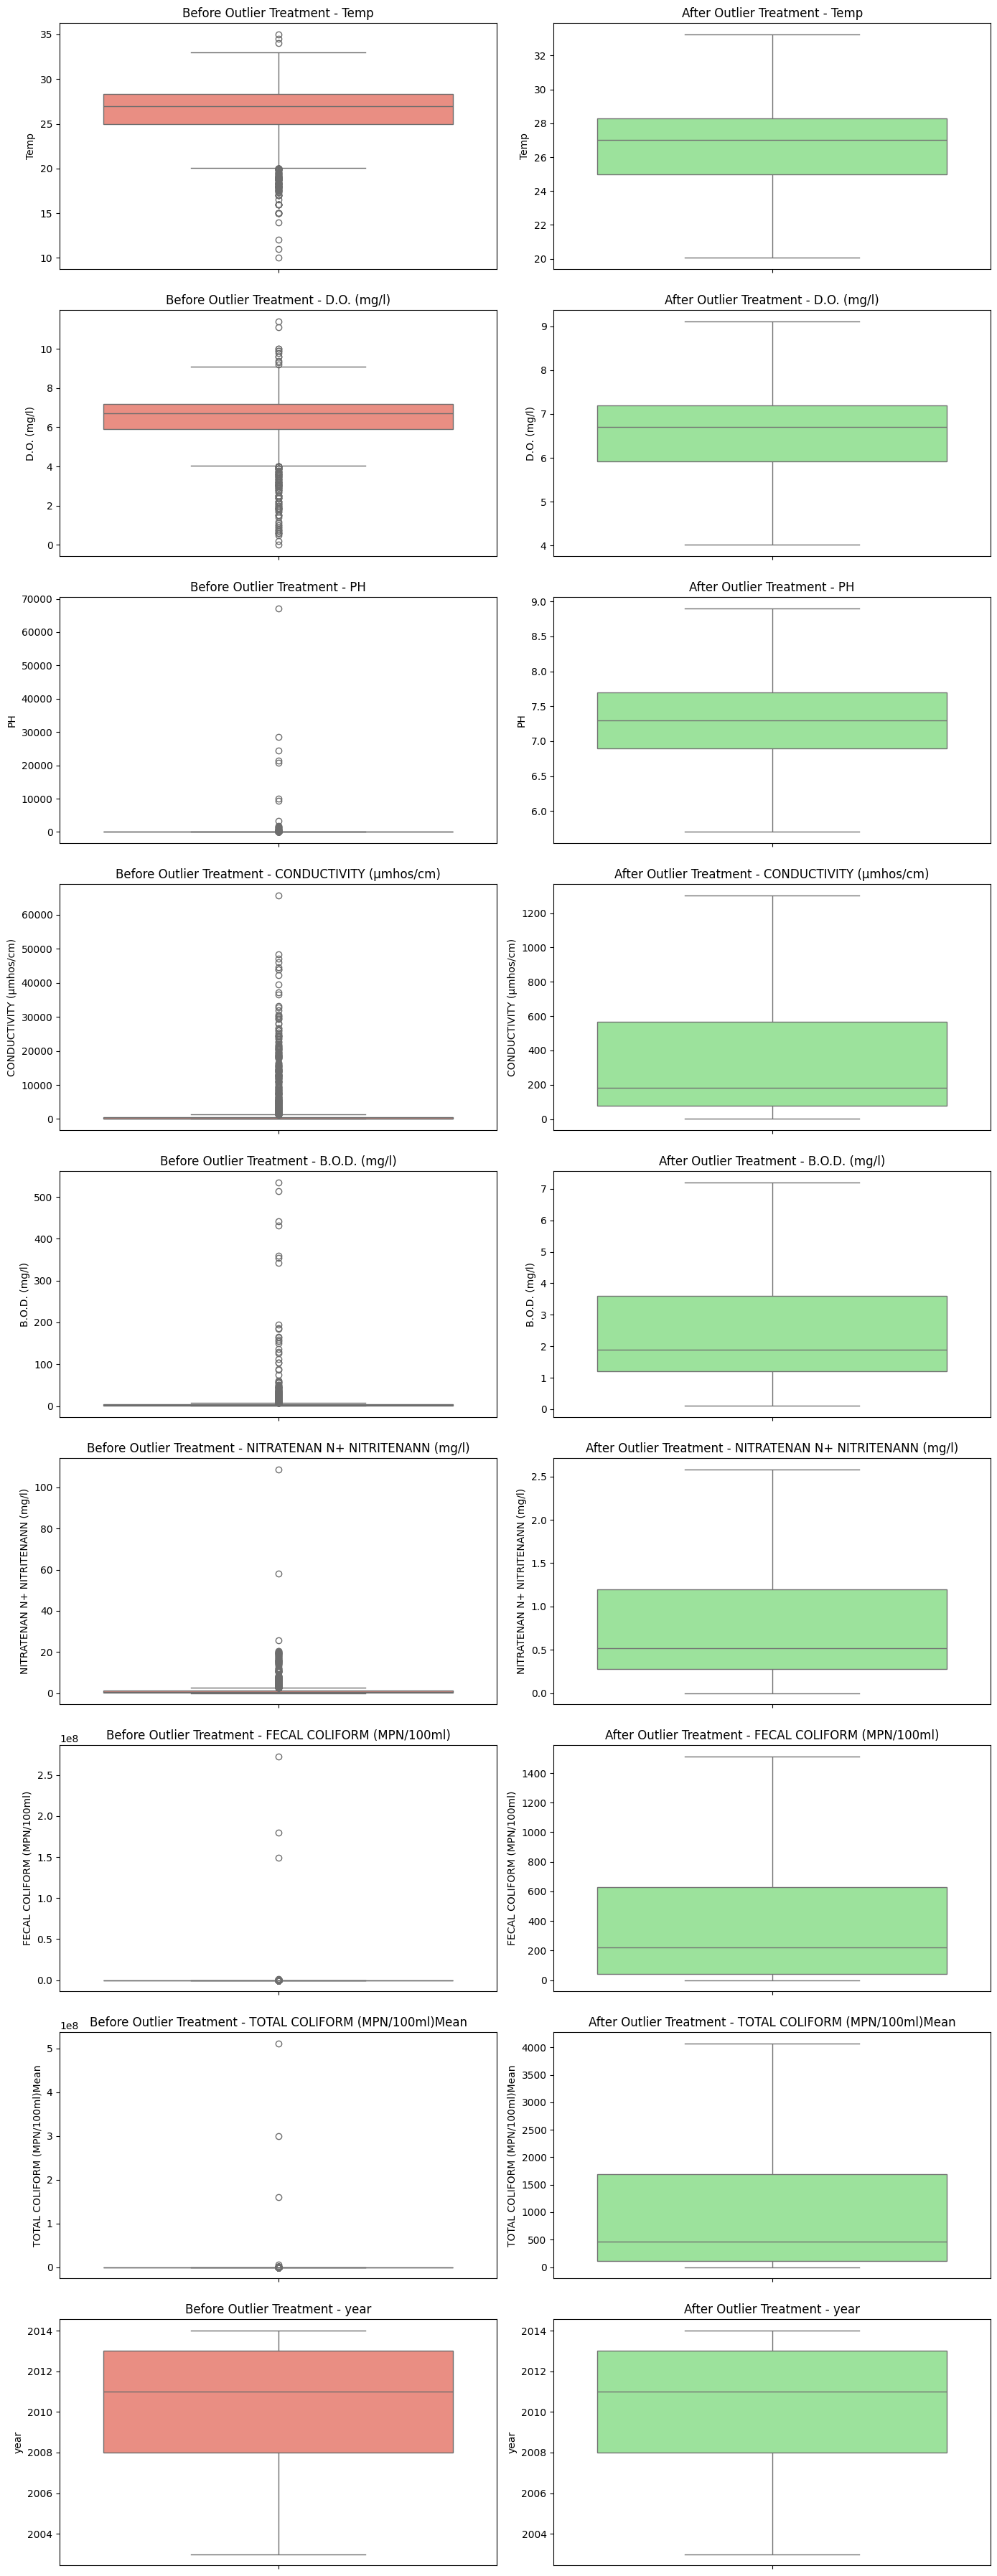

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=2, figsize=(14, 4 * len(numeric_cols)))

# Loop through each numeric column to show before and after
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df_before_outliers[col], ax=axes[i, 0], color='salmon')
    axes[i, 0].set_title(f"Before Outlier Treatment - {col}")
    
    sns.boxplot(y=df[col], ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f"After Outlier Treatment - {col}")

plt.tight_layout()
plt.show()

## Step 8: Clean and Encode `STATE` Column

In [76]:
# Step 8: Clean and Encode `STATE` Column

import numpy as np

# --- Normalize State Strings ---
def normalize_state_string(s):
    if pd.isna(s):
        return np.nan
    s = str(s).upper().strip()
    s = s.replace('&', ' AND ').replace(',', ' AND ')
    s = s.replace('DADRA AND NAGAR AND HAVELI', 'DAMAN AND DIU')
    s = ' '.join(s.split())  # Remove double spaces
    return s

df['STATE'] = df['STATE'].replace(['NAN', 'NA', ''], np.nan)
df['STATE'] = df['STATE'].apply(normalize_state_string)

# --- Extract from LOCATIONS ---
def extract_state_from_location(loc):
    if pd.isna(loc):
        return np.nan
    loc = str(loc).upper()
    
    # Special cases
    if 'KABBANI' in loc or 'BHAVANI' in loc:
        return 'KERALA'
    if 'CHANDIGARH' in loc:
        return 'PUNJAB'
    
    state_patterns = {
        'ANDHRA PRADESH': ['ANDHRA', 'A.P.'],
        'DAMAN AND DIU': ['DAMAN', 'DIU', 'DADRA', 'HAVELI'],
        'GOA': ['GOA', 'ZUARI', 'MANDOVI'],
        'GUJARAT': ['GUJARAT'],
        'HARYANA': ['HARYANA'],
        'HIMACHAL PRADESH': ['HIMACHAL'],
        'KARNATAKA': ['KARNATAKA'],
        'KERALA': ['KERALA'],
        'MADHYA PRADESH': ['MADHYA'],
        'MAHARASHTRA': ['MAHARASHTRA'],
        'MANIPUR': ['MANIPUR'],
        'MEGHALAYA': ['MEGHALAYA'],
        'MIZORAM': ['MIZORAM'],
        'ODISHA': ['ODISHA', 'ORISSA'],
        'PONDICHERRY': ['PONDICHERRY'],
        'PUNJAB': ['PUNJAB'],
        'RAJASTHAN': ['RAJASTHAN'],
        'TAMIL NADU': ['TAMILNADU', 'TAMIL NADU'],
        'TRIPURA': ['TRIPURA'],
        'UTTAR PRADESH': ['UTTAR', 'PRADESH']
    }
    
    for state, patterns in state_patterns.items():
        if any(pattern in loc for pattern in patterns):
            return state
    return np.nan

location_based_states = df['LOCATIONS'].apply(extract_state_from_location)
df['STATE'] = df['STATE'].fillna(location_based_states)

# --- Fill using STATION CODE mapping ---
station_state_map = df.dropna(subset=['STATE']).drop_duplicates('STATION CODE')\
                      .set_index('STATION CODE')['STATE'].to_dict()

df['STATE'] = df.apply(
    lambda row: station_state_map.get(row['STATION CODE'], row['STATE']),
    axis=1
)

# --- Final standardization ---
state_mapping = {
    'ANDHRA PRADESH': ['ANDHRA', 'A.P.'],
    'DAMAN AND DIU': ['DAMAN', 'DIU', 'DADRA', 'HAVELI'],
    'GOA': ['GOA', 'ZUARI', 'MANDOVI'],
    'GUJARAT': ['GUJARAT'],
    'HARYANA': ['HARYANA'],
    'HIMACHAL PRADESH': ['HIMACHAL'],
    'KARNATAKA': ['KARNATAKA'],
    'KERALA': ['KERALA'],
    'MADHYA PRADESH': ['MADHYA'],
    'MAHARASHTRA': ['MAHARASHTRA'],
    'MANIPUR': ['MANIPUR'],
    'MEGHALAYA': ['MEGHALAYA'],
    'MIZORAM': ['MIZORAM'],
    'ODISHA': ['ODISHA', 'ORISSA'],
    'PONDICHERRY': ['PONDICHERRY'],
    'PUNJAB': ['PUNJAB'],
    'RAJASTHAN': ['RAJASTHAN'],
    'TAMIL NADU': ['TAMILNADU', 'TAMIL NADU'],
    'TRIPURA': ['TRIPURA'],
    'UTTAR PRADESH': ['UTTAR', 'PRADESH']
}

def standardize_state(state):
    if pd.isna(state):
        return np.nan
    state = normalize_state_string(state)
    for std, variants in state_mapping.items():
        if any(v in state for v in variants):
            return std
    return state

df['STATE'] = df['STATE'].apply(standardize_state)

# --- Option A: Drop if still missing ---
df = df.dropna(subset=['STATE'])  # Only truly unrecoverable ones


# Verification
print("✅ Cleaned and standardized STATE column")
print(df['STATE'].value_counts())

✅ Cleaned and standardized STATE column
STATE
KERALA              530
MAHARASHTRA         223
GOA                 181
MEGHALAYA           151
ANDHRA PRADESH      144
MANIPUR             123
PUNJAB              114
GUJARAT              98
TAMIL NADU           96
ODISHA               73
HARYANA              43
MIZORAM              36
PONDICHERRY          33
DAMAN AND DIU        32
KARNATAKA            30
RAJASTHAN            28
TRIPURA              27
HIMACHAL PRADESH     26
MADHYA PRADESH        2
Name: count, dtype: int64


## Step 9: One-Hot Encode `STATE`

In [77]:

df = pd.concat([df, pd.get_dummies(df['STATE'], prefix='STATE', dtype=int)], axis=1)


## Step 10: Final Feature Set Preparation


In [78]:

# Drop non-numeric and redundant columns
df_clean = df.drop(columns=['LOCATIONS', 'STATION CODE', 'STATE'])

# Show final dataframe
df_clean


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year,STATE_ANDHRA PRADESH,...,STATE_MAHARASHTRA,STATE_MANIPUR,STATE_MEGHALAYA,STATE_MIZORAM,STATE_ODISHA,STATE_PONDICHERRY,STATE_PUNJAB,STATE_RAJASTHAN,STATE_TAMIL NADU,STATE_TRIPURA
0,30.6,6.7,7.5,203.0,1.8965,0.100,11.000,27.000,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
1,29.8,5.7,7.2,189.0,2.0000,0.200,1511.625,4068.625,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
2,29.5,6.3,6.9,179.0,1.7000,0.100,1511.625,4068.625,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
3,29.7,5.8,6.9,64.0,3.8000,0.500,1511.625,4068.625,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
4,29.5,5.8,7.3,83.0,1.9000,0.400,1511.625,4068.625,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,27.0,7.9,8.9,7.2,2.7000,0.518,0.518,202.000,2003.0,0,...,0,0,0,0,0,0,0,0,1,0
1987,29.0,7.5,8.9,6.3,2.6000,0.155,0.155,315.000,2003.0,0,...,0,0,0,0,0,0,0,0,1,0
1988,28.0,7.6,8.9,6.2,1.2000,0.516,221.000,570.000,2003.0,0,...,0,0,0,0,0,0,0,0,0,1
1989,28.0,7.7,8.9,6.5,1.3000,0.516,221.000,562.000,2003.0,0,...,0,0,0,0,0,0,0,0,0,1


## Step 11: Feature Scaling

In [79]:
# Numeric water parameters (need scaling)
numeric_cols = ['Temp', 'D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)', 
               'B.O.D. (mg/l)', 'NITRATENAN N+ NITRITENANN (mg/l)',
               'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean', 'year']

# One-hot encoded states (should NOT be scaled)
state_cols = [col for col in df.columns if col.startswith('STATE_')]

# Other columns (like 'Cluster' if exists)
other_cols = list(set(df.columns) - set(numeric_cols) - set(state_cols))

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_clean.copy()  # Preserve original data

# Scale only numeric columns
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [81]:
print("Scaled numeric features summary:")
print(df_scaled[numeric_cols].describe().loc[['mean', 'std']])

Scaled numeric features summary:
              Temp   D.O. (mg/l)            PH  CONDUCTIVITY (µmhos/cm)  \
mean -4.106151e-16  2.570808e-16  4.927382e-16             2.677925e-17   
std   1.000251e+00  1.000251e+00  1.000251e+00             1.000251e+00   

      B.O.D. (mg/l)  NITRATENAN N+ NITRITENANN (mg/l)  \
mean  -2.856453e-17                      1.142581e-16   
std    1.000251e+00                      1.000251e+00   

      FECAL COLIFORM (MPN/100ml)  TOTAL COLIFORM (MPN/100ml)Mean          year  
mean               -3.570567e-18                   -6.427020e-17 -4.570325e-15  
std                 1.000251e+00                    1.000251e+00  1.000251e+00  


In [82]:
df_scaled

,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year,STATE_ANDHRA PRADESH,...,STATE_MAHARASHTRA,STATE_MANIPUR,STATE_MEGHALAYA,STATE_MIZORAM,STATE_ODISHA,STATE_PONDICHERRY,STATE_PUNJAB,STATE_RAJASTHAN,STATE_TAMIL NADU,STATE_TRIPURA
0,1.426943,0.212185,0.285922,-0.439784,-0.385844,-0.914394,-0.815974,-0.789033,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
1,1.157093,-0.716602,-0.201747,-0.471501,-0.338132,-0.798248,1.923634,2.005554,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
2,1.055899,-0.159329,-0.689417,-0.494156,-0.476427,-0.914394,1.923634,2.005554,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
3,1.123361,-0.623723,-0.689417,-0.754685,0.491641,-0.449809,1.923634,2.005554,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
4,1.055899,-0.623723,-0.039191,-0.711641,-0.384230,-0.565956,1.923634,2.005554,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,0.212617,1.326730,2.561713,-0.883364,-0.015442,-0.428903,-0.835111,-0.668029,-2.302119,0,...,0,0,0,0,0,0,0,0,1,0
1987,0.887242,0.955215,2.561713,-0.885403,-0.061541,-0.850513,-0.835774,-0.589895,-2.302119,0,...,0,0,0,0,0,0,0,0,1,0
1988,0.549929,1.048094,2.561713,-0.885629,-0.706920,-0.431226,-0.432589,-0.413575,-2.302119,0,...,0,0,0,0,0,0,0,0,0,1
1989,0.549929,1.140972,2.561713,-0.884950,-0.660821,-0.431226,-0.432589,-0.419106,-2.302119,0,...,0,0,0,0,0,0,0,0,0,1


## PART 2
Author: Jeffrey Loo

In [83]:
# Required Libraries
from sklearn.cluster import (
    AffinityPropagation, AgglomerativeClustering, Birch, BisectingKMeans,
    DBSCAN, KMeans, MeanShift, MiniBatchKMeans, OPTICS, SpectralClustering
)
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
import pandas as pd
import numpy as np

# Store results
results = []

# Dictionary of clustering models
clustering_algorithms = {
    "AffinityPropagation": AffinityPropagation(),
    "AgglomerativeClustering": AgglomerativeClustering(n_clusters=3),
    "Birch": Birch(n_clusters=3),
    "BisectingKMeans": BisectingKMeans(n_clusters=3),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=10),
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "MeanShift": MeanShift(),
    "MiniBatchKMeans": MiniBatchKMeans(n_clusters=3, random_state=42),
    "OPTICS": OPTICS(min_samples=10),
    "SpectralClustering": SpectralClustering(n_clusters=3, affinity='rbf', random_state=42)
}

# Run all models and compute evaluation metrics
for name, model in clustering_algorithms.items():
    try:
        if name == "HDBSCAN":
            labels = model.fit_predict(df_scaled)
        else:
            labels = model.fit(df_scaled).labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters <= 1:
            sil_score = -1
            db_score = -1
            ch_score = -1
        else:
            sil_score = silhouette_score(df_scaled, labels)
            db_score = davies_bouldin_score(df_scaled, labels)
            ch_score = calinski_harabasz_score(df_scaled, labels)

        results.append((name, round(sil_score, 4), round(db_score, 4), round(ch_score, 2), n_clusters))

    except Exception as e:
        results.append((name, f"Error: {str(e)}", "N/A", "N/A", "N/A"))

# Create and sort result DataFrame
results_df = pd.DataFrame(results, columns=["Algorithm", "Silhouette Score", "Davies-Bouldin Score", "Calinski-Harabasz Score", "Clusters"])
results_df = results_df.sort_values(by="Silhouette Score", ascending=False)

# Show Results
results_df

c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



,Algorithm,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score,Clusters
7,MeanShift,0.3040,1.4305,469.02,2
0,AffinityPropagation,0.2349,1.3257,112.51,104
10,SpectralClustering,0.2345,1.1315,281.65,3
8,MiniBatchKMeans,0.2009,1.9190,363.39,3
1,AgglomerativeClustering,0.1818,1.5641,361.12,3
2,Birch,0.1672,2.1113,327.07,3
3,BisectingKMeans,0.1470,2.2256,369.39,3
6,KMeans,0.1447,2.0982,389.21,3
5,HDBSCAN,0.0536,1.6021,90.24,19
9,OPTICS,-0.1911,1.2760,26.08,26


## PART 3: Analyze significant patterns and influencing factors.
Author: Ng Zher Xian

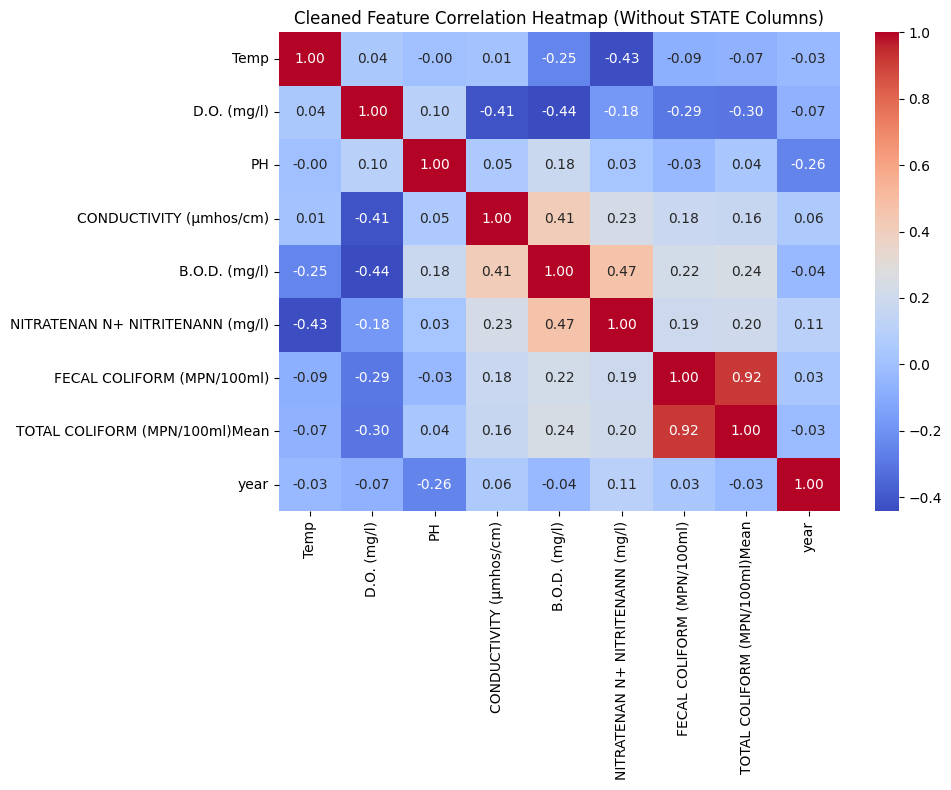

In [84]:
# Drop one-hot encoded STATE columns
numerical_df = df_scaled.loc[:, ~df_scaled.columns.str.startswith("STATE_")]

# Then plot heatmap again
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cleaned Feature Correlation Heatmap (Without STATE Columns)")
plt.tight_layout()
plt.show()


## Key Insight
### 1. Strong Positive Correlations
FECAL COLIFORM vs TOTAL COLIFORM: 0.92

Interpretation: These two features are highly redundant, as expected, since total coliforms often include fecal coliforms. You could drop one without losing much information.

✔️ Important for clustering — redundant features should be reduced.

B.O.D. (mg/l) vs NITRATENANN N+ NITRITENANN (mg/l): 0.47

CONDUCTIVITY vs B.O.D. (mg/l): 0.41

CONDUCTIVITY vs D.O. (mg/l): -0.41

✔️ These show moderate relationships and may form underlying dimensions (e.g., pollution indicators).

### 2. Moderate Negative Correlations
Temp vs NITRATENANN: -0.43

Temp vs B.O.D.: -0.25

D.O. vs B.O.D.: -0.44

Interpretation: As Dissolved Oxygen (D.O.) decreases, Biochemical Oxygen Demand (B.O.D.) increases — a classic sign of polluted water bodies.

✔️ This inverse relationship is useful to define high vs low water quality clusters.

### 3. Low/Weak Correlations
Features like PH, year, and Temp have low correlations with most others.

Interpretation: They might still carry some variance for clustering, but less influence on defining relationships.


In [85]:
# Convert one-hot STATE columns into a single 'STATE' column
state_columns = [col for col in df_scaled.columns if col.startswith('STATE_')]
df_scaled['STATE'] = df_scaled[state_columns].idxmax(axis=1).str.replace('STATE_', '')

# Drop the one-hot columns to clean up
df_cleaned = df_scaled.drop(columns=state_columns)


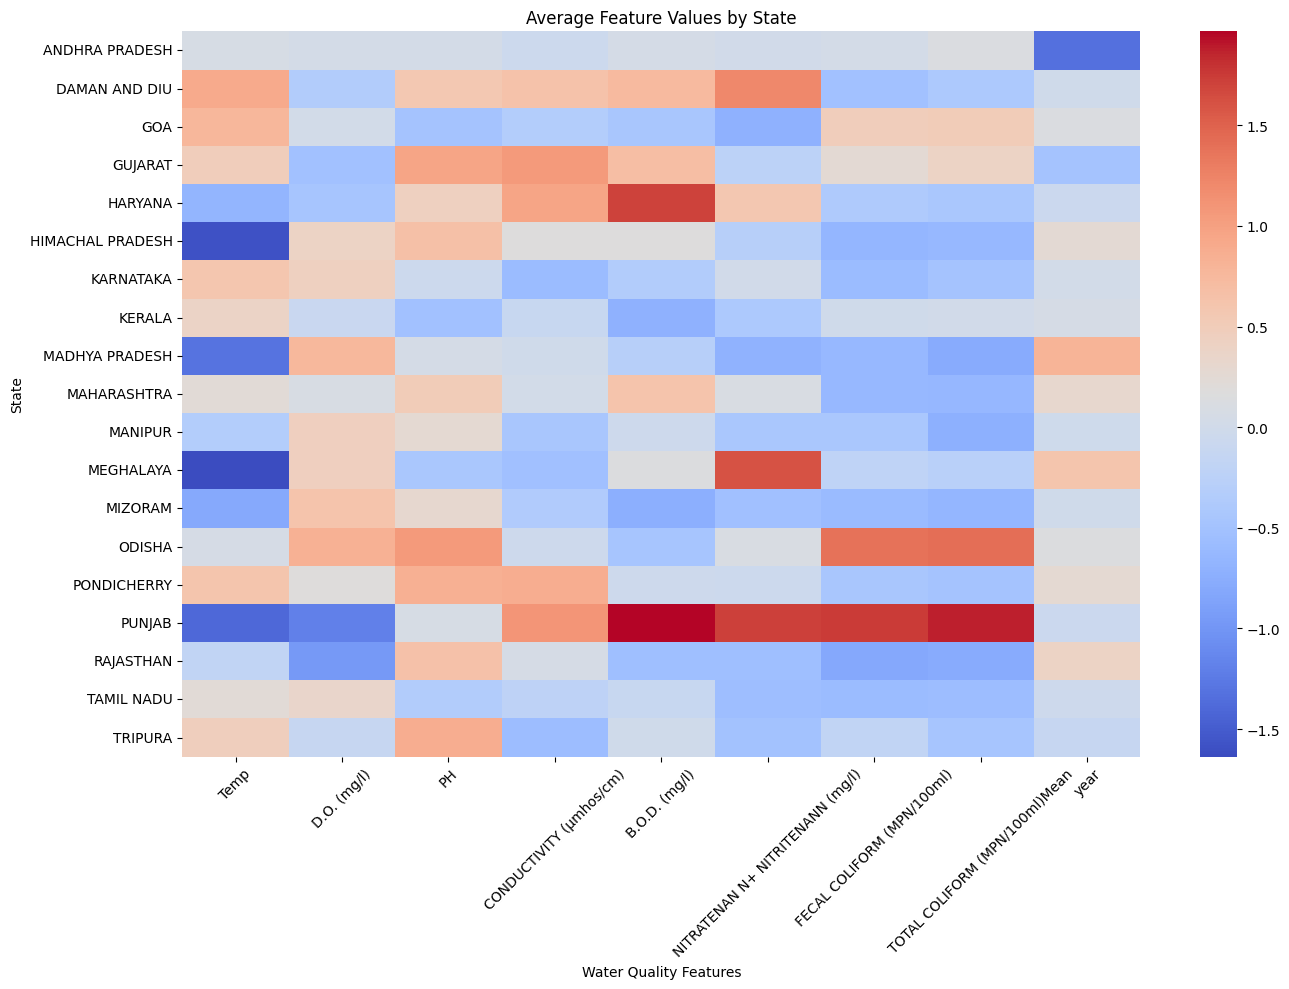

In [86]:
# Group by STATE and calculate the mean for each feature
state_feature_means = df_cleaned.groupby('STATE').mean(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(state_feature_means, cmap='coolwarm', annot=False)
plt.title("Average Feature Values by State")
plt.xlabel("Water Quality Features")
plt.ylabel("State")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1. Pollution-Heavy States
Punjab, Odisha, and Gujarat show high B.O.D., Nitrate, Fecal Coliform, and Total Coliform.

🔥 This suggests poor water quality, likely due to urban runoff, agriculture, or industrial waste.

These are states you could tag as "high pollution clusters" in further clustering analysis.

##  2. Better Water Quality States
Himachal Pradesh, Meghalaya, and Mizoram show low B.O.D., low Nitrate, and high D.O.

✅ Indicates relatively clean water bodies, probably due to forest cover, low population density, or effective treatment.



# PCA Visualisation

In [87]:
from sklearn.decomposition import PCA
from sklearn.cluster import (
    MeanShift, SpectralClustering, MiniBatchKMeans,
    AgglomerativeClustering, Birch, BisectingKMeans
)
import matplotlib.pyplot as plt
import seaborn as sns

# This is your clean numerical dataset (no STATE_ columns)
X = numerical_df  # Assuming you've already removed STATE_ one-hot columns


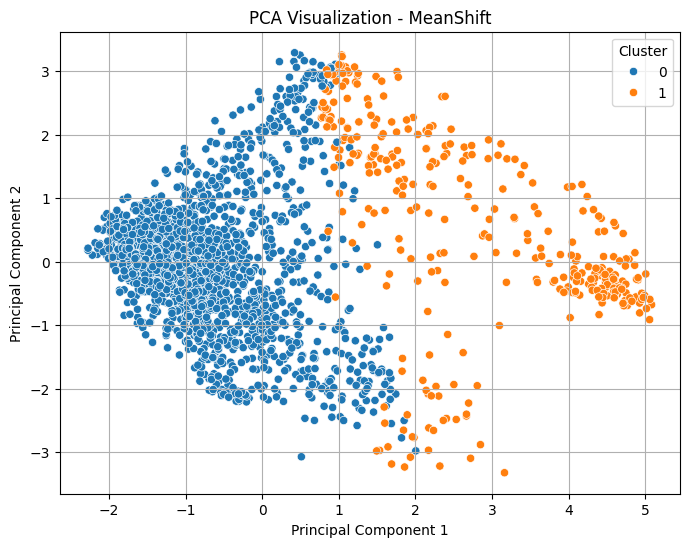

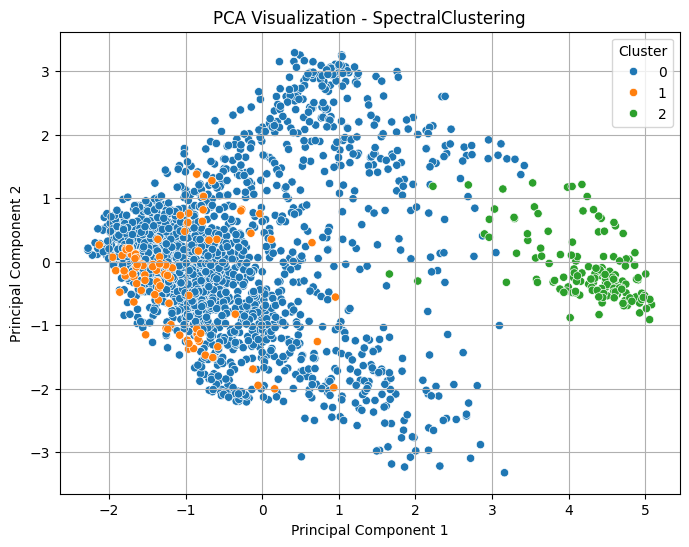

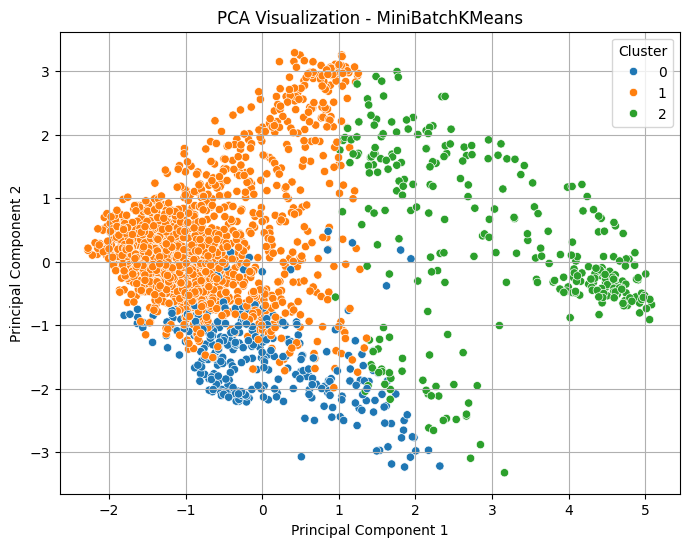

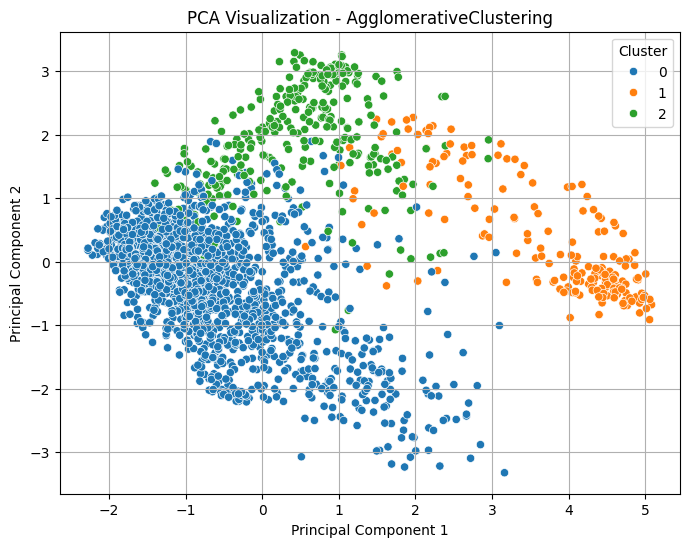

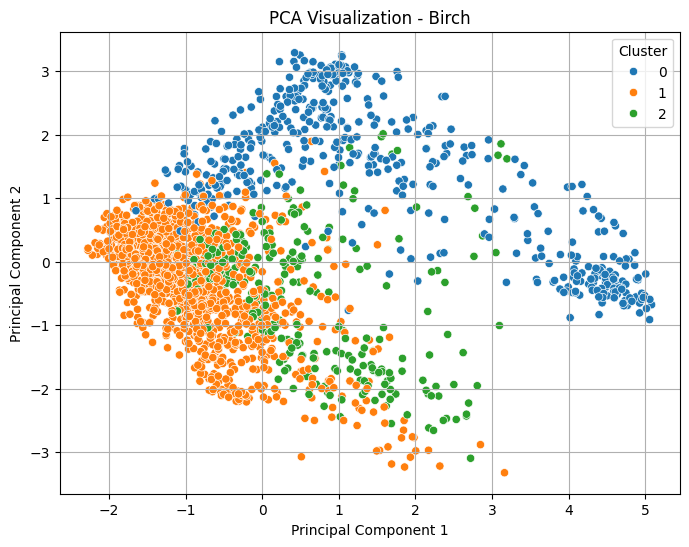

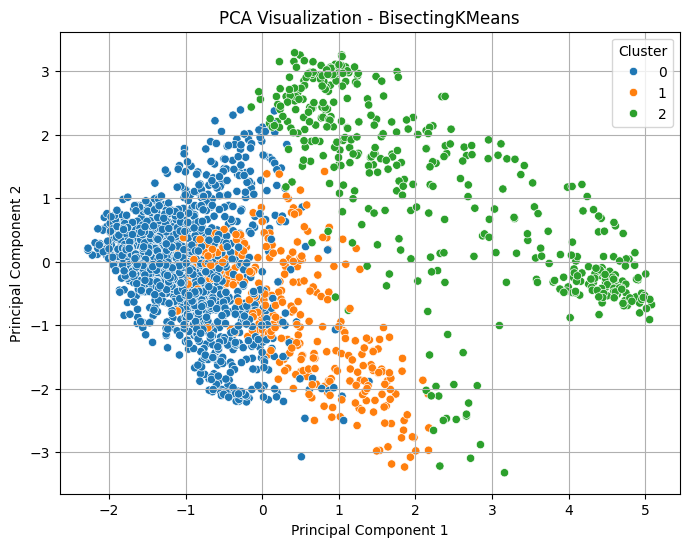

In [88]:
def visualize_clustering_with_pca(model, name, X):
    labels = model.fit_predict(X)

    # PCA transformation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10')
    plt.title(f"PCA Visualization - {name}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

# Define and visualize each model
visualize_clustering_with_pca(MeanShift(), "MeanShift", X)
visualize_clustering_with_pca(SpectralClustering(n_clusters=3, random_state=42), "SpectralClustering", X)
visualize_clustering_with_pca(MiniBatchKMeans(n_clusters=3, random_state=42), "MiniBatchKMeans", X)
visualize_clustering_with_pca(AgglomerativeClustering(n_clusters=3), "AgglomerativeClustering", X)
visualize_clustering_with_pca(Birch(n_clusters=3), "Birch", X)
visualize_clustering_with_pca(BisectingKMeans(n_clusters=3, random_state=42), "BisectingKMeans", X)


In [89]:
from sklearn.cluster import MeanShift

# 1. Fit and get labels
ms_model = MeanShift()
labels_ms = ms_model.fit_predict(numerical_df)

# 2. Attach labels to the data
df_with_labels = numerical_df.copy()
df_with_labels['cluster'] = labels_ms

# 3. Group and analyze
cluster_mean_stats = df_with_labels.groupby('cluster').mean()
display(cluster_mean_stats)


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
cluster,,,,,,,,,
0,0.109895,0.187286,-0.058441,-0.158834,-0.229071,-0.196046,-0.343437,-0.348526,0.005796
1,-0.507878,-0.865537,0.270084,0.734049,1.058646,0.906019,1.587185,1.610700,-0.026788


Using MeanShift clustering, two distinct water quality profiles emerged. Cluster 0 is characterized by higher dissolved oxygen levels and lower contamination indicators, suggesting cleaner water conditions. In contrast, Cluster 1 shows elevated BOD, nitrate, fecal and total coliform levels, indicating significant pollution. Key influencing factors driving this separation include D.O., B.O.D., coliform counts, and nitrate levels. These features can be considered critical decision variables for evaluating water quality in the dataset.

In [90]:
from sklearn.cluster import SpectralClustering

# Spectral Clustering
sc_model = SpectralClustering(n_clusters=3, random_state=42)
labels_sc = sc_model.fit_predict(numerical_df)

# Attach labels and analyze
df_sc = numerical_df.copy()
df_sc['cluster'] = labels_sc
cluster_stats_sc = df_sc.groupby('cluster').mean()
display(cluster_stats_sc)


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
cluster,,,,,,,,,
0,0.105910,0.092185,-0.133224,-0.045737,-0.172994,-0.128813,-0.133616,-0.176324,0.117175
1,0.084514,0.689363,2.561713,-0.884950,-0.076562,-0.427468,-0.676812,-0.009596,-2.294767
2,-1.232918,-1.424462,0.028739,1.016489,1.978776,1.684763,1.880749,1.977819,-0.001515


Spectral Clustering identified 3 clusters representing varying water quality profiles. Cluster 2 clearly represents heavily polluted samples, with high BOD, nitrate, and coliform counts, and very low dissolved oxygen. Cluster 1 indicates clean water with good oxygenation, though the pH is significantly elevated, suggesting possible chemical imbalance. Cluster 0 falls in between, showing moderately clean conditions. The most influential variables driving cluster separation were D.O., B.O.D., nitrate levels, and coliform counts.

In [91]:
from sklearn.cluster import MiniBatchKMeans

# MiniBatch K-Means
mbk_model = MiniBatchKMeans(n_clusters=3, random_state=42)
labels_mbk = mbk_model.fit_predict(numerical_df)

# Attach labels and analyze
df_mbk = numerical_df.copy()
df_mbk['cluster'] = labels_mbk
cluster_stats_mbk = df_mbk.groupby('cluster').mean()
display(cluster_stats_mbk)


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
cluster,,,,,,,,,
0,-0.967710,0.312716,-0.124306,-0.045224,0.126533,1.133936,-0.589271,-0.629218,0.419343
1,0.375591,0.174613,-0.025463,-0.208177,-0.335289,-0.518352,-0.195634,-0.197752,-0.089538
2,-0.585696,-1.104227,0.246882,0.959094,1.327222,1.028244,1.497787,1.550622,-0.066174


MiniBatchKMeans discovered 3 distinct water quality profiles. Cluster 1 contains the cleanest samples, with warm temperatures and low concentrations of pollutants. Cluster 2 reflects the most polluted waters, with high BOD, nitrate, and coliform levels, and dangerously low dissolved oxygen. Cluster 0 represents colder water systems with high nitrate content, suggesting chemically contaminated but not organically polluted sources. Key drivers of cluster separation include D.O., B.O.D., nitrate, and coliform concentrations.

In [92]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering
agg_model = AgglomerativeClustering(n_clusters=3)
labels_agg = agg_model.fit_predict(numerical_df)

# Attach labels and analyze
df_agg = numerical_df.copy()
df_agg['cluster'] = labels_agg
cluster_stats_agg = df_agg.groupby('cluster').mean()
display(cluster_stats_agg)


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
cluster,,,,,,,,,
0,0.049204,0.128405,0.021924,-0.059849,-0.100096,-0.099284,-0.526678,-0.503737,-0.022068
1,-0.812331,-1.209010,0.190621,1.128274,1.553875,1.248100,1.840480,1.904848,-0.069175
2,0.324498,0.197547,-0.249288,-0.494635,-0.589807,-0.376055,1.412612,1.248055,0.163465


Agglomerative Clustering separated the dataset into three clusters. Cluster 0 is the cleanest, with minimal pollution and above-average oxygen levels. Cluster 1 represents extremely polluted water, with high BOD, nitrate, and coliform concentrations, as well as low oxygen — a typical signature of sewage or industrial runoff. Cluster 2 shows a conflicting profile: low BOD and nitrate, but high bacterial contamination, likely from untreated runoff or poor sanitation.

In [93]:
from sklearn.cluster import Birch

# Birch Clustering
birch_model = Birch(n_clusters=3)
labels_birch = birch_model.fit_predict(numerical_df)

# Attach labels and analyze
df_birch = numerical_df.copy()
df_birch['cluster'] = labels_birch
cluster_stats_birch = df_birch.groupby('cluster').mean()
display(cluster_stats_birch)


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
cluster,,,,,,,,,
0,-0.142825,-0.388606,-0.134470,0.076918,0.307719,0.257364,1.546050,1.505483,0.019982
1,-0.041533,0.273985,0.045393,-0.470828,-0.183578,-0.108629,-0.556063,-0.530013,-0.031072
2,0.429589,-0.508572,0.038206,1.906411,0.258035,0.021153,-0.291195,-0.333223,0.099769


Birch clustering clearly separates water samples into clean, polluted, and chemically influenced groups. Cluster 1 shows the best water quality, with high dissolved oxygen and very low pollutants. Cluster 0 exhibits the highest organic and bacterial pollution levels, suggesting poor sanitation or untreated sewage. Cluster 2 shows elevated conductivity and slightly high B.O.D., pointing toward water influenced by industrial or chemical waste. Dissolved Oxygen, B.O.D., and Coliform counts are the strongest influencing variables.

In [94]:
from sklearn.cluster import BisectingKMeans

# Bisecting K-Means
bkm_model = BisectingKMeans(n_clusters=3, random_state=42)
labels_bkm = bkm_model.fit_predict(numerical_df)

# Attach labels and analyze
df_bkm = numerical_df.copy()
df_bkm['cluster'] = labels_bkm
cluster_stats_bkm = df_bkm.groupby('cluster').mean()
display(cluster_stats_bkm)


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
cluster,,,,,,,,,
0,0.021434,0.365725,-0.005344,-0.558969,-0.362363,-0.205240,-0.456595,-0.441017,-0.033830
1,0.261804,-0.501061,-0.083459,1.461482,0.501493,0.057051,-0.502398,-0.501203,0.084862
2,-0.262789,-0.659591,0.079517,0.472611,0.649651,0.542689,1.691743,1.646298,0.031366


BisectingKMeans effectively identifies three water quality profiles. Cluster 0 represents the cleanest water sources with high dissolved oxygen and low pollutants. Cluster 1 suggests chemical or mineral-rich water with moderate organic impact but low bacterial contamination. Cluster 2 is heavily polluted, with high organic matter, bacterial load, and low oxygen — suggesting untreated wastewater or urban runoff. Influencing features include D.O., B.O.D., nitrate, and coliform counts

# Step 4
Author: Wong Chyi Keat

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_samples, davies_bouldin_score, calinski_harabasz_score

In [96]:
def detect_outliers_by_distance(model, X, labels, threshold=2.5):
    centers = model.cluster_centers_
    distances = np.linalg.norm(X - centers[labels], axis=1)
    z_scores = (distances - np.mean(distances)) / np.std(distances)
    outliers = np.where(z_scores > threshold)[0]
    print(f"{model.__class__.__name__} - Outliers detected (z > {threshold}): {len(outliers)}")
    return outliers, z_scores


In [97]:

def plot_silhouette_distribution(X, labels, name):
    sil_samples = silhouette_samples(X, labels)
    sil_mean = np.mean(sil_samples)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    plt.figure(figsize=(8, 4))
    sns.histplot(sil_samples, kde=True, bins=20)
    plt.title(f"Silhouette Score Distribution - {name}")
    plt.xlabel("Silhouette Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    print(f"📊 {name} Metrics:")
    print(f"   • Mean Silhouette Score       : {sil_mean:.4f}")
    print(f"   • Davies-Bouldin Score        : {db_score:.4f}")
    print(f"   • Calinski-Harabasz Score     : {ch_score:.2f}")

    return sil_samples

In [98]:
def print_cluster_distribution(labels, name):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} Cluster Distribution:")
    for u, c in zip(unique, counts):
        print(f"Cluster {u}: {c} points")


## MiniBatchKMeans

MiniBatchKMeans - Outliers detected (z > 2.5): 12


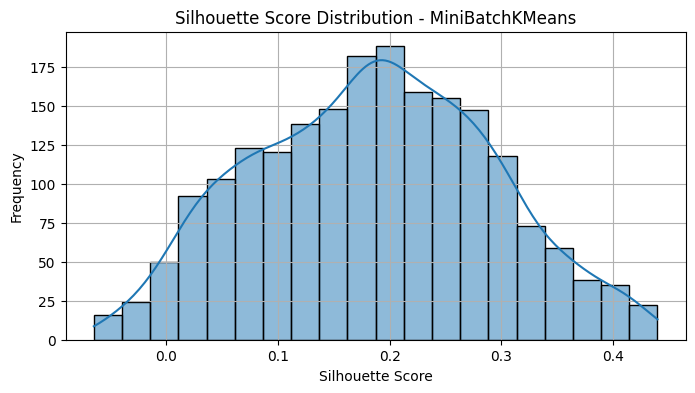

📊 MiniBatchKMeans Metrics:
   • Mean Silhouette Score       : 0.1854
   • Davies-Bouldin Score        : 1.8185
   • Calinski-Harabasz Score     : 395.75

MiniBatchKMeans Cluster Distribution:
Cluster 0: 336 points
Cluster 1: 1346 points
Cluster 2: 308 points


In [99]:
mini_model = MiniBatchKMeans(n_clusters=3, random_state=42)
labels_mini = mini_model.fit_predict(X)

outliers_mini, z_scores_mini = detect_outliers_by_distance(mini_model, X, labels_mini)
plot_silhouette_distribution(X, labels_mini, "MiniBatchKMeans")
print_cluster_distribution(labels_mini, "MiniBatchKMeans")

## BisectingKMeans

BisectingKMeans - Outliers detected (z > 2.5): 28


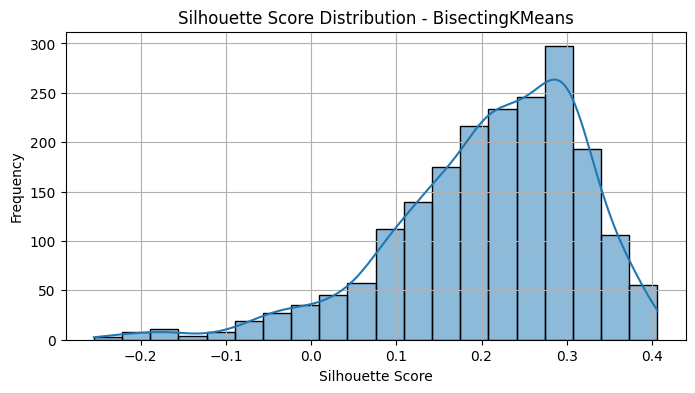

📊 BisectingKMeans Metrics:
   • Mean Silhouette Score       : 0.2098
   • Davies-Bouldin Score        : 1.8482
   • Calinski-Harabasz Score     : 422.90

BisectingKMeans Cluster Distribution:
Cluster 0: 1229 points
Cluster 1: 331 points
Cluster 2: 430 points


In [100]:
bkm_model = BisectingKMeans(n_clusters=3, random_state=42)
labels_bkm = bkm_model.fit_predict(X)

outliers_bkm, z_scores_bkm = detect_outliers_by_distance(bkm_model, X, labels_bkm)
plot_silhouette_distribution(X, labels_bkm, "BisectingKMeans")
print_cluster_distribution(labels_bkm, "BisectingKMeans")


## Birch

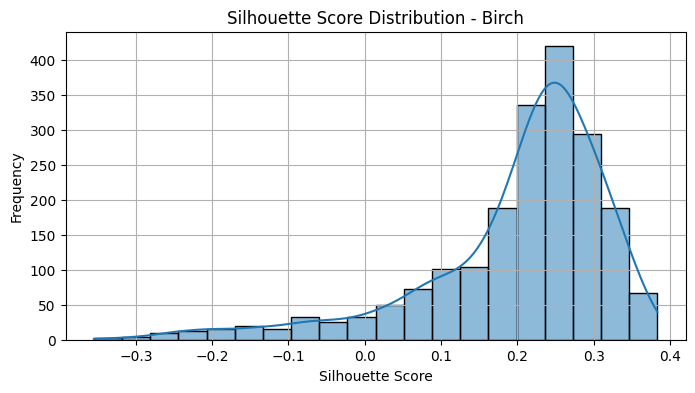

📊 Birch Metrics:
   • Mean Silhouette Score       : 0.2006
   • Davies-Bouldin Score        : 1.7342
   • Calinski-Harabasz Score     : 366.44

Birch Cluster Distribution:
Cluster 0: 491 points
Cluster 1: 1218 points
Cluster 2: 281 points


In [101]:
birch_model = Birch(n_clusters=3)
labels_birch = birch_model.fit_predict(X)

plot_silhouette_distribution(X, labels_birch, "Birch")
print_cluster_distribution(labels_birch, "Birch")


## MeanShift

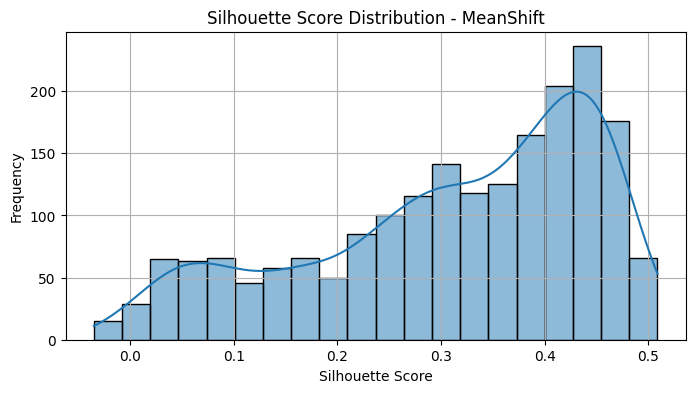

📊 MeanShift Metrics:
   • Mean Silhouette Score       : 0.3101
   • Davies-Bouldin Score        : 1.5001
   • Calinski-Harabasz Score     : 523.88

MeanShift Cluster Distribution:
Cluster 0: 1636 points
Cluster 1: 354 points


In [102]:
ms_model = MeanShift()
labels_ms = ms_model.fit_predict(X)

plot_silhouette_distribution(X, labels_ms, "MeanShift")
print_cluster_distribution(labels_ms, "MeanShift")


## Agglomerative

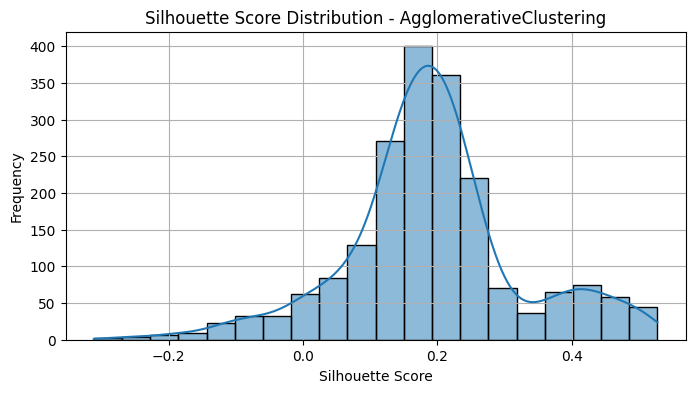

📊 AgglomerativeClustering Metrics:
   • Mean Silhouette Score       : 0.1911
   • Davies-Bouldin Score        : 1.4906
   • Calinski-Harabasz Score     : 399.51

AgglomerativeClustering Cluster Distribution:
Cluster 0: 1495 points
Cluster 1: 206 points
Cluster 2: 289 points


In [103]:
agg_model = AgglomerativeClustering(n_clusters=3)
labels_agg = agg_model.fit_predict(X)

plot_silhouette_distribution(X, labels_agg, "AgglomerativeClustering")
print_cluster_distribution(labels_agg, "AgglomerativeClustering")


## Spectral Clustering

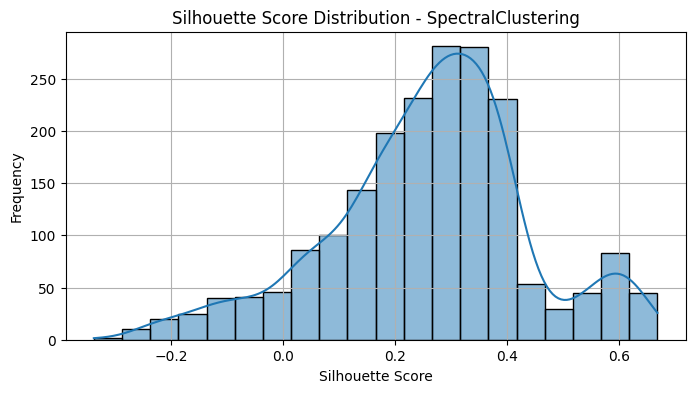

📊 SpectralClustering Metrics:
   • Mean Silhouette Score       : 0.2592
   • Davies-Bouldin Score        : 1.0476
   • Calinski-Harabasz Score     : 324.85

SpectralClustering Cluster Distribution:
Cluster 0: 1745 points
Cluster 1: 89 points
Cluster 2: 156 points


In [104]:
spec_model = SpectralClustering(n_clusters=3, random_state=42)
labels_spec = spec_model.fit_predict(X)

plot_silhouette_distribution(X, labels_spec, "SpectralClustering")
print_cluster_distribution(labels_spec, "SpectralClustering")


## Plot PCA plot with outliers 

## Only for MiniBatchKMeans and BisectingKMeans
### Because only this 2 have centroids → We can compute distances from each point to its cluster center.

This allows us to identify numerical outliers using z-score thresholds (distance-based logic).

In [105]:
def plot_clusters_with_outliers(X, labels, outlier_indices, model_name):
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10', alpha=0.6, legend='full')
    
    # Overlay outliers in red
    plt.scatter(X_pca[outlier_indices, 0], X_pca[outlier_indices, 1], 
                c='red', edgecolor='black', label='Outliers', s=60, marker='X')

    plt.title(f"PCA Visualization with Outliers - {model_name}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

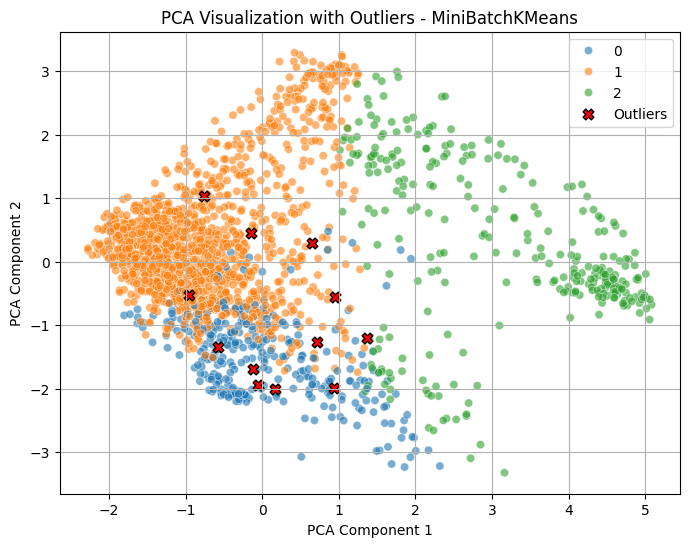

In [106]:
plot_clusters_with_outliers(X, labels_mini, outliers_mini, "MiniBatchKMeans")


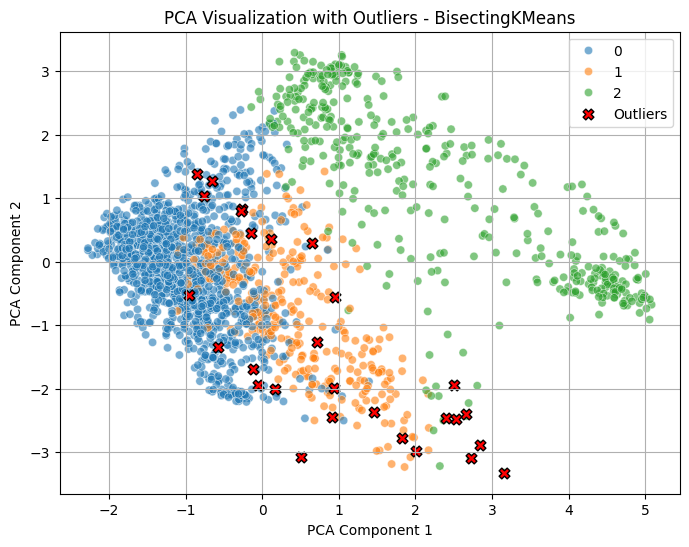

In [107]:
plot_clusters_with_outliers(X, labels_bkm, outliers_bkm, "BisectingKMeans")

# Step 5
Author: Wong Chyi Keat

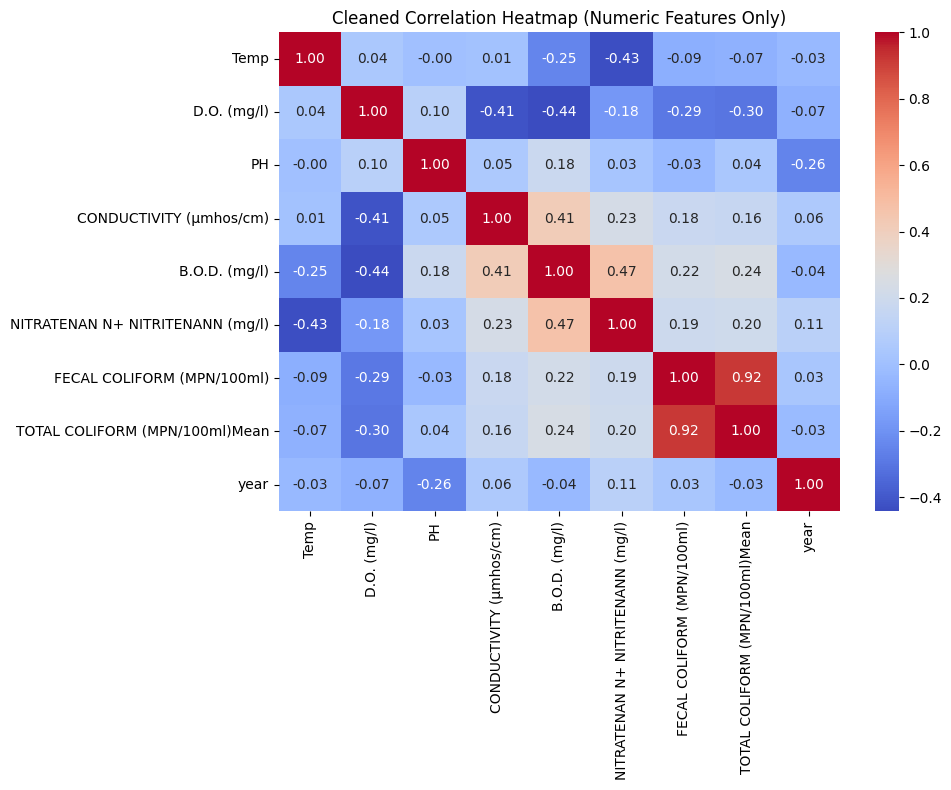

In [108]:
# Drop the original 'STATE' string column + one-hot encoded STATE_ columns
numerical_df = df_scaled.drop(columns=['STATE'], errors='ignore')
numerical_df = numerical_df.loc[:, ~numerical_df.columns.str.startswith("STATE_")]

# Ensure only numeric columns are selected
numerical_df = numerical_df.select_dtypes(include=[np.number])

# Plot the heatmap
plt.figure(figsize=(10, 8))
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Cleaned Correlation Heatmap (Numeric Features Only)")
plt.tight_layout()
plt.show()


In [109]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with low variance
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(numerical_df)

# Get feature names
all_features = numerical_df.columns
kept_features = all_features[selector.get_support()]
removed_features = all_features[~selector.get_support()]

# Output
print(f"Original features: {numerical_df.shape[1]}")
print(f"Remaining after low-variance filtering: {X_var.shape[1]}")
print(f"Removed features ({len(removed_features)}):")
for col in removed_features:
    print(" -", col)


Original features: 9
Remaining after low-variance filtering: 9
Removed features (0):


In [110]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_var)

print(f"Reduced to {X_pca.shape[1]} PCA components (95% variance retained).")


Reduced to 8 PCA components (95% variance retained).


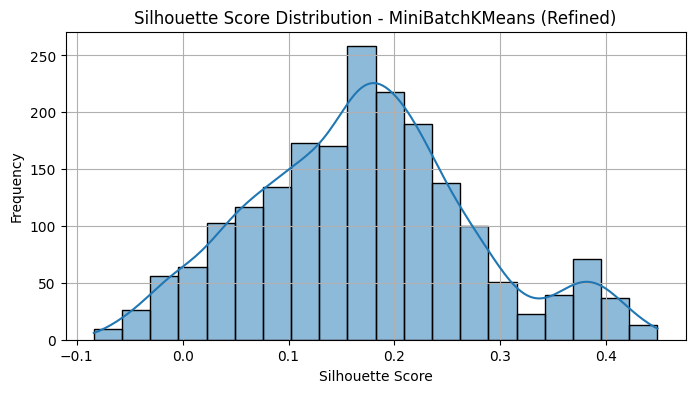

📊 MiniBatchKMeans (Refined) Metrics:
   • Mean Silhouette Score       : 0.1711
   • Davies-Bouldin Score        : 1.8153
   • Calinski-Harabasz Score     : 401.60

MiniBatchKMeans (Refined) Cluster Distribution:
Cluster 0: 356 points
Cluster 1: 1311 points
Cluster 2: 323 points


In [111]:
mini_refined = MiniBatchKMeans(n_clusters=3, random_state=42)
labels_mini_refined = mini_refined.fit_predict(X_pca)

plot_silhouette_distribution(X_pca, labels_mini_refined, "MiniBatchKMeans (Refined)")
print_cluster_distribution(labels_mini_refined, "MiniBatchKMeans (Refined)")


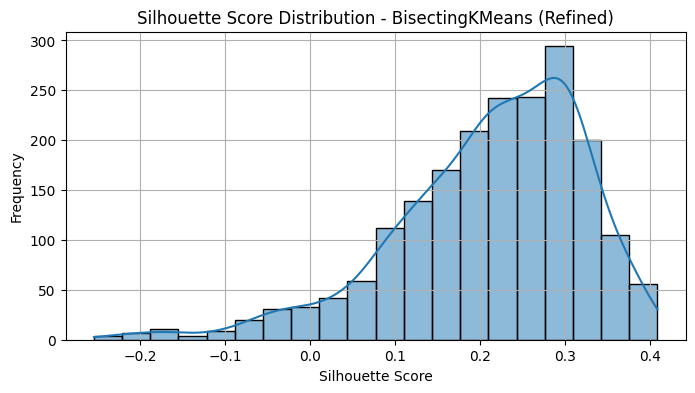

📊 BisectingKMeans (Refined) Metrics:
   • Mean Silhouette Score       : 0.2119
   • Davies-Bouldin Score        : 1.8375
   • Calinski-Harabasz Score     : 428.00

BisectingKMeans (Refined) Cluster Distribution:
Cluster 0: 1229 points
Cluster 1: 330 points
Cluster 2: 431 points


In [112]:
bkm_refined = BisectingKMeans(n_clusters=3, random_state=42)
labels_bkm_refined = bkm_refined.fit_predict(X_pca)

plot_silhouette_distribution(X_pca, labels_bkm_refined, "BisectingKMeans (Refined)")
print_cluster_distribution(labels_bkm_refined, "BisectingKMeans (Refined)")


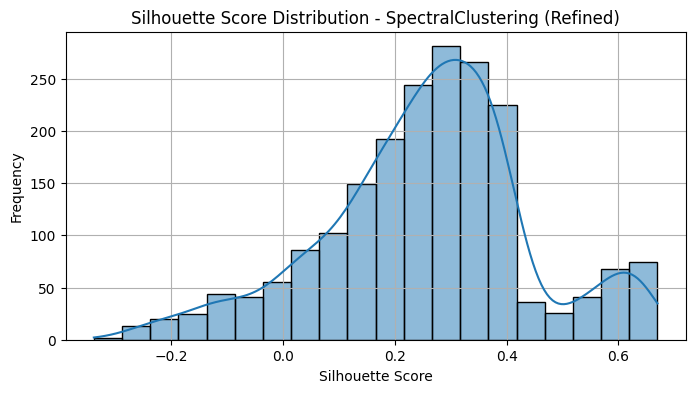

📊 SpectralClustering (Refined) Metrics:
   • Mean Silhouette Score       : 0.2557
   • Davies-Bouldin Score        : 1.0214
   • Calinski-Harabasz Score     : 327.94

SpectralClustering (Refined) Cluster Distribution:
Cluster 0: 1745 points
Cluster 1: 156 points
Cluster 2: 89 points


In [113]:
spec_refined = SpectralClustering(n_clusters=3, random_state=42)
labels_spec_refined = spec_refined.fit_predict(X_pca)

plot_silhouette_distribution(X_pca, labels_spec_refined, "SpectralClustering (Refined)")
print_cluster_distribution(labels_spec_refined, "SpectralClustering (Refined)")


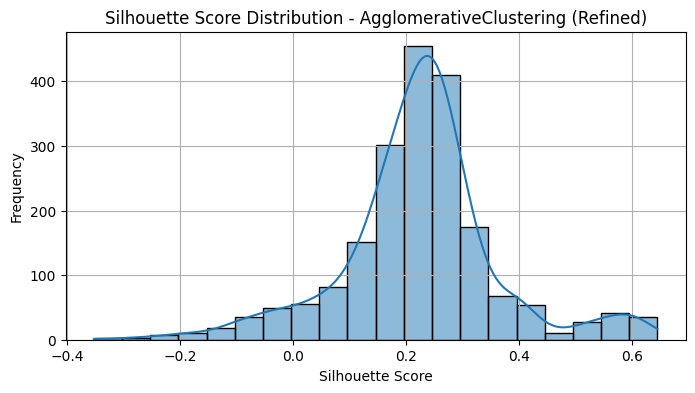

📊 AgglomerativeClustering (Refined) Metrics:
   • Mean Silhouette Score       : 0.2231
   • Davies-Bouldin Score        : 1.4298
   • Calinski-Harabasz Score     : 415.71

AgglomerativeClustering (Refined) Cluster Distribution:
Cluster 0: 1515 points
Cluster 1: 331 points
Cluster 2: 144 points


In [114]:
agg_refined = AgglomerativeClustering(n_clusters=3)
labels_agg_refined = agg_refined.fit_predict(X_pca)

plot_silhouette_distribution(X_pca, labels_agg_refined, "AgglomerativeClustering (Refined)")
print_cluster_distribution(labels_agg_refined, "AgglomerativeClustering (Refined)")


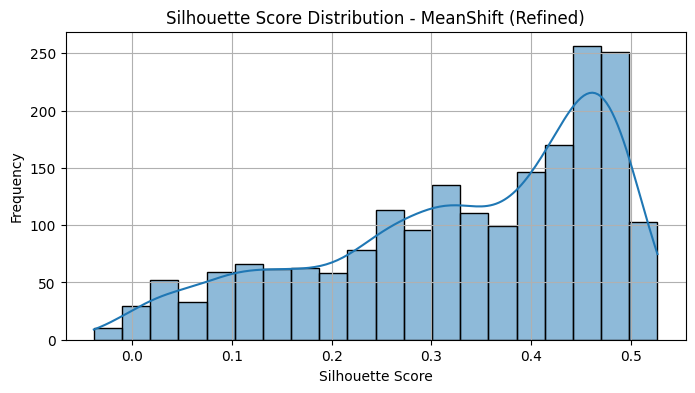

📊 MeanShift (Refined) Metrics:
   • Mean Silhouette Score       : 0.3328
   • Davies-Bouldin Score        : 1.3043
   • Calinski-Harabasz Score     : 520.27

MeanShift (Refined) Cluster Distribution:
Cluster 0: 1717 points
Cluster 1: 273 points


In [115]:
ms_refined = MeanShift()
labels_ms_refined = ms_refined.fit_predict(X_pca)

plot_silhouette_distribution(X_pca, labels_ms_refined, "MeanShift (Refined)")
print_cluster_distribution(labels_ms_refined, "MeanShift (Refined)")


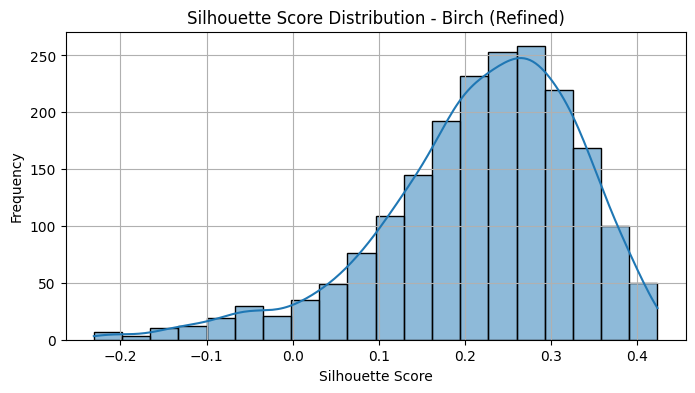

📊 Birch (Refined) Metrics:
   • Mean Silhouette Score       : 0.2180
   • Davies-Bouldin Score        : 1.8263
   • Calinski-Harabasz Score     : 429.75

Birch (Refined) Cluster Distribution:
Cluster 0: 413 points
Cluster 1: 348 points
Cluster 2: 1229 points


In [116]:
birch_refined = Birch(n_clusters=3)
labels_birch_refined = birch_refined.fit_predict(X_pca)

plot_silhouette_distribution(X_pca, labels_birch_refined, "Birch (Refined)")
print_cluster_distribution(labels_birch_refined, "Birch (Refined)")


## Silhouette score table (Before v.s After Refined data)

In [117]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def get_cluster_scores(X, labels, model_name, results_list):
    if len(set(labels)) < 2:
        sil_score = -1
        db_score = -1
        ch_score = -1
    else:
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)

    print(f"📊 {model_name} Clustering Metrics:")
    print(f"   • Silhouette Score       : {sil_score:.4f}")
    print(f"   • Davies-Bouldin Score   : {db_score:.4f}")
    print(f"   • Calinski-Harabasz     : {ch_score:.2f}")

    results_list.append((model_name, round(sil_score, 4), round(db_score, 4), round(ch_score, 2)))

In [118]:
silhouette_before = []

get_cluster_scores(X, labels_mini, "MiniBatchKMeans", silhouette_before)
get_cluster_scores(X, labels_bkm, "BisectingKMeans", silhouette_before)
get_cluster_scores(X, labels_spec, "SpectralClustering", silhouette_before)
get_cluster_scores(X, labels_agg, "AgglomerativeClustering", silhouette_before)
get_cluster_scores(X, labels_ms, "MeanShift", silhouette_before)
get_cluster_scores(X, labels_birch, "Birch", silhouette_before)

print("\n")

silhouette_after = []

get_cluster_scores(X_pca, labels_mini_refined, "MiniBatchKMeans", silhouette_after)
get_cluster_scores(X_pca, labels_bkm_refined, "BisectingKMeans", silhouette_after)
get_cluster_scores(X_pca, labels_spec_refined, "SpectralClustering", silhouette_after)
get_cluster_scores(X_pca, labels_agg_refined, "AgglomerativeClustering", silhouette_after)
get_cluster_scores(X_pca, labels_ms_refined, "MeanShift", silhouette_after)
get_cluster_scores(X_pca, labels_birch_refined, "Birch", silhouette_after)


📊 MiniBatchKMeans Clustering Metrics:
   • Silhouette Score       : 0.1854
   • Davies-Bouldin Score   : 1.8185
   • Calinski-Harabasz     : 395.75
📊 BisectingKMeans Clustering Metrics:
   • Silhouette Score       : 0.2098
   • Davies-Bouldin Score   : 1.8482
   • Calinski-Harabasz     : 422.90
📊 SpectralClustering Clustering Metrics:
   • Silhouette Score       : 0.2592
   • Davies-Bouldin Score   : 1.0476
   • Calinski-Harabasz     : 324.85
📊 AgglomerativeClustering Clustering Metrics:
   • Silhouette Score       : 0.1911
   • Davies-Bouldin Score   : 1.4906
   • Calinski-Harabasz     : 399.51
📊 MeanShift Clustering Metrics:
   • Silhouette Score       : 0.3101
   • Davies-Bouldin Score   : 1.5001
   • Calinski-Harabasz     : 523.88
📊 Birch Clustering Metrics:
   • Silhouette Score       : 0.2006
   • Davies-Bouldin Score   : 1.7342
   • Calinski-Harabasz     : 366.44


📊 MiniBatchKMeans Clustering Metrics:
   • Silhouette Score       : 0.1711
   • Davies-Bouldin Score   : 1.8153
   

In [119]:
import pandas as pd

# Create detailed DataFrames
df_before = pd.DataFrame(silhouette_before, columns=[
    "Model", "Silhouette (Before)", "Davies-Bouldin (Before)", "Calinski-Harabasz (Before)"
])

df_after = pd.DataFrame(silhouette_after, columns=[
    "Model", "Silhouette (After)", "Davies-Bouldin (After)", "Calinski-Harabasz (After)"
])

# Merge the two tables
df_comparison = pd.merge(df_before, df_after, on="Model")
df_comparison = df_comparison.sort_values(by="Silhouette (After)", ascending=False).reset_index(drop=True)

# Display
df_comparison.style.set_caption("Clustering Metrics Comparison Before vs After Refinement")

,Model,Silhouette (Before),Davies-Bouldin (Before),Calinski-Harabasz (Before),Silhouette (After),Davies-Bouldin (After),Calinski-Harabasz (After)
0,MeanShift,0.310100,1.500100,523.880000,0.332800,1.304300,520.270000
1,SpectralClustering,0.259200,1.047600,324.850000,0.255700,1.021400,327.940000
2,AgglomerativeClustering,0.191100,1.490600,399.510000,0.223100,1.429800,415.710000
3,Birch,0.200600,1.734200,366.440000,0.218000,1.826300,429.750000
4,BisectingKMeans,0.209800,1.848200,422.900000,0.211900,1.837500,428.000000
5,MiniBatchKMeans,0.185400,1.818500,395.750000,0.171100,1.815300,401.600000


## STEP 6
Author: Mark Chye

In [120]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_all_clustering(X_pca, cluster_range=range(2, 9)):
    results = []

    for k in cluster_range:
        print(f"\n🔹 Testing with k={k} clusters")
        models = {
            "MiniBatchKMeans": MiniBatchKMeans(n_clusters=k, random_state=42),
            "SpectralClustering": SpectralClustering(n_clusters=k, random_state=42),
            "AgglomerativeClustering": AgglomerativeClustering(n_clusters=k),
            "Birch": Birch(n_clusters=k),
            "BisectingKMeans": BisectingKMeans(n_clusters=k, random_state=42)
        }

        for name, model in models.items():
            try:
                labels = model.fit_predict(X_pca)
                sil_score = silhouette_score(X_pca, labels)
                db_score = davies_bouldin_score(X_pca, labels)
                ch_score = calinski_harabasz_score(X_pca, labels)

                results.append((name, k, round(sil_score, 4), round(db_score, 4), round(ch_score, 2)))
                print(f"✅ {name} with k={k}:")
                print(f"   • Silhouette Score      = {sil_score:.4f}")
                print(f"   • Davies-Bouldin Score  = {db_score:.4f}")
                print(f"   • Calinski-Harabasz     = {ch_score:.2f}")

            except Exception as e:
                print(f"⚠️ {name} with k={k} failed: {e}")

    return results

In [121]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_meanshift(X_pca):
    model = MeanShift()
    labels = model.fit_predict(X_pca)
    
    if len(set(labels)) < 2:
        print("⚠️ MeanShift only found one cluster, skipping metrics.")
        return None
    else:
        sil_score = silhouette_score(X_pca, labels)
        db_score = davies_bouldin_score(X_pca, labels)
        ch_score = calinski_harabasz_score(X_pca, labels)

        print("✅ MeanShift Clustering Metrics:")
        print(f"   • Silhouette Score      = {sil_score:.4f}")
        print(f"   • Davies-Bouldin Score  = {db_score:.4f}")
        print(f"   • Calinski-Harabasz     = {ch_score:.2f}")

        # Plot PCA
        plt.figure()
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='plasma', s=10)
        plt.title(f'MeanShift - PCA Visualization')
        plt.xlabel('PCA1')
        plt.ylabel('PCA2')
        plt.grid(True)
        plt.show()

        return (sil_score, db_score, ch_score)

In [122]:
from collections import defaultdict
import matplotlib.pyplot as plt

def visualize_best_clusters(X_pca, results):
    grouped = defaultdict(list)

    # Collect (k, silhouette_score) for each algorithm
    for algo, k, sil_score, _, _ in results:
        grouped[algo].append((k, sil_score))

    print("📊 All Silhouette Scores by Algorithm:")
    for algo, k_scores in grouped.items():
        print(f"\n🔸 {algo}")
        for k, score in sorted(k_scores, key=lambda x: x[0]):
            print(f"  k = {k} --> Silhouette Score: {score:.4f}")

    # Visualize the best model per algorithm
    for algo, k_scores in grouped.items():
        best_k, best_score = max(k_scores, key=lambda x: x[1])
        print(f"\n📈 Visualizing {algo} with best k = {best_k} (score = {best_score})")

        # Refit the best model
        if algo == "MiniBatchKMeans":
            model = MiniBatchKMeans(n_clusters=best_k, random_state=42)
        elif algo == "SpectralClustering":
            model = SpectralClustering(n_clusters=best_k, random_state=42)
        elif algo == "AgglomerativeClustering":
            model = AgglomerativeClustering(n_clusters=best_k)
        elif algo == "Birch":
            model = Birch(n_clusters=best_k)
        elif algo == "BisectingKMeans":
            model = BisectingKMeans(n_clusters=best_k, random_state=42)
        else:
            continue

        labels = model.fit_predict(X_pca)
        plt.figure()
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set2', s=10)
        plt.title(f"{algo} (Best k={best_k})")
        plt.xlabel("PCA1")
        plt.ylabel("PCA2")
        plt.grid(True)
        plt.show()


🔹 Testing with k=2 clusters
✅ MiniBatchKMeans with k=2:
   • Silhouette Score      = 0.3054
   • Davies-Bouldin Score  = 1.5752
   • Calinski-Harabasz     = 529.54
✅ SpectralClustering with k=2:
   • Silhouette Score      = 0.3524
   • Davies-Bouldin Score  = 0.9374
   • Calinski-Harabasz     = 433.67
✅ AgglomerativeClustering with k=2:
   • Silhouette Score      = 0.2598
   • Davies-Bouldin Score  = 1.6866
   • Calinski-Harabasz     = 499.90
✅ Birch with k=2:
   • Silhouette Score      = 0.2883
   • Davies-Bouldin Score  = 1.5671
   • Calinski-Harabasz     = 529.44
✅ BisectingKMeans with k=2:
   • Silhouette Score      = 0.2973
   • Davies-Bouldin Score  = 1.5820
   • Calinski-Harabasz     = 550.82

🔹 Testing with k=3 clusters
✅ MiniBatchKMeans with k=3:
   • Silhouette Score      = 0.1711
   • Davies-Bouldin Score  = 1.8153
   • Calinski-Harabasz     = 401.60
✅ SpectralClustering with k=3:
   • Silhouette Score      = 0.2557
   • Davies-Bouldin Score  = 1.0214
   • Calinski-Harabasz

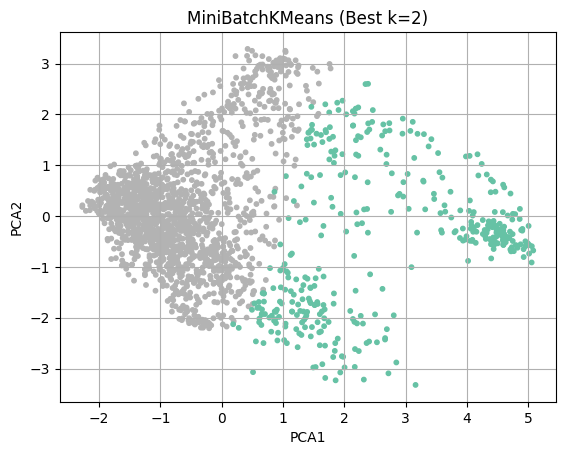


📈 Visualizing SpectralClustering with best k = 2 (score = 0.3524)


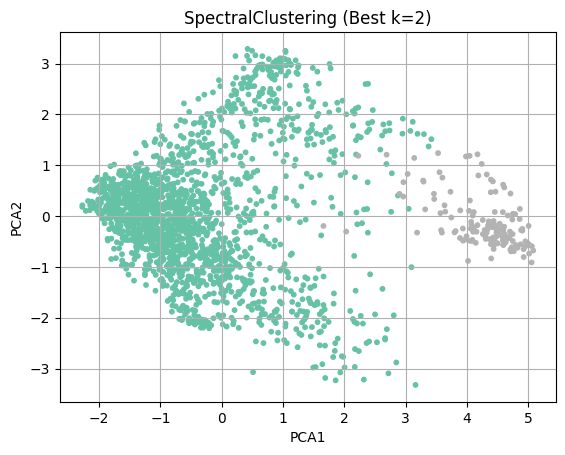


📈 Visualizing AgglomerativeClustering with best k = 2 (score = 0.2598)


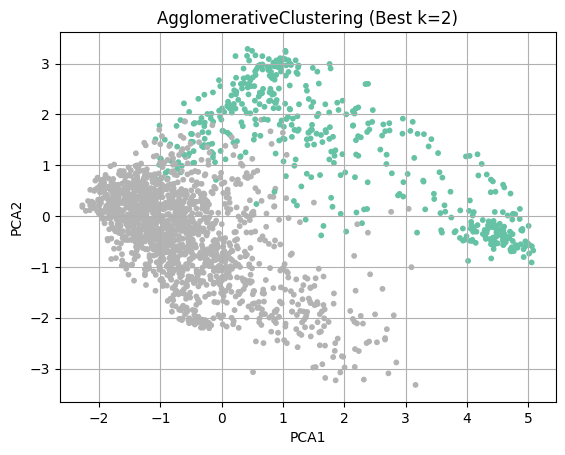


📈 Visualizing Birch with best k = 2 (score = 0.2883)


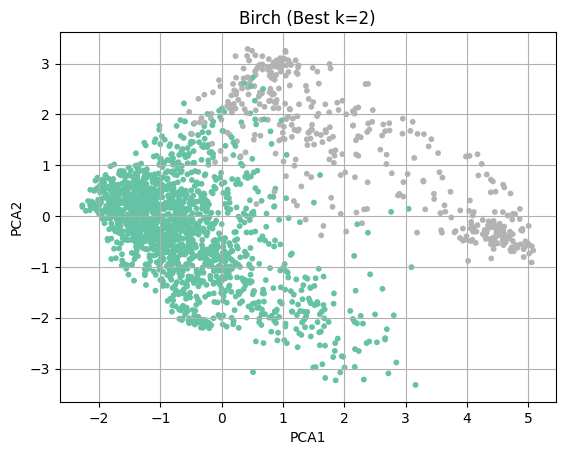


📈 Visualizing BisectingKMeans with best k = 2 (score = 0.2973)


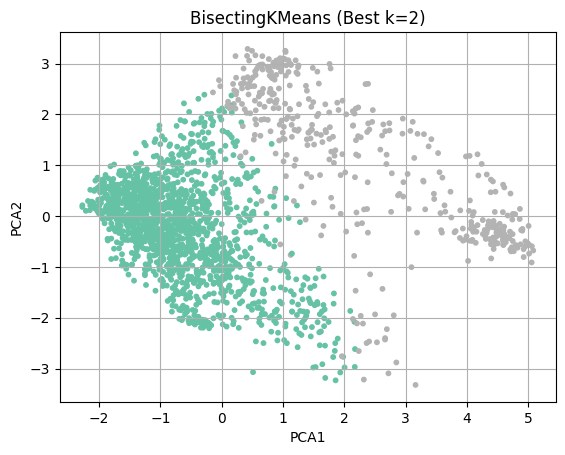

In [123]:
results = evaluate_all_clustering(X_pca)
visualize_best_clusters(X_pca, results)

✅ MeanShift Clustering Metrics:
   • Silhouette Score      = 0.3328
   • Davies-Bouldin Score  = 1.3043
   • Calinski-Harabasz     = 520.27


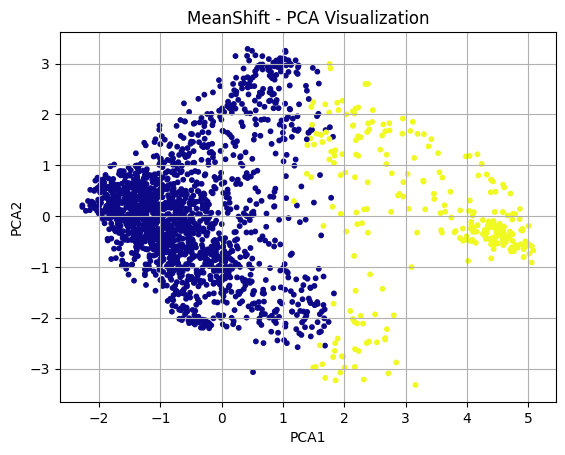

In [124]:
meanshift_score=evaluate_meanshift(X_pca)

In [125]:
def summarize_best_clusters(results, meanshift_tuple=None):
    best_summary = {}

    for algo, k, sil_score, db_score, ch_score in results:
        if algo not in best_summary or sil_score > best_summary[algo]["Silhouette"]:
            best_summary[algo] = {
                "k": k,
                "Silhouette": sil_score,
                "Davies-Bouldin": db_score,
                "Calinski-Harabasz": ch_score
            }

    if meanshift_tuple is not None:
        best_summary["MeanShift"] = {
            "k": "auto",
            "Silhouette": meanshift_tuple[0],
            "Davies-Bouldin": meanshift_tuple[1],
            "Calinski-Harabasz": meanshift_tuple[2]
        }

    # Print formatted table
    print("📌 Best Cluster Summary by Algorithm:")
    print("{:<25} {:<8} {:<18} {:<20} {:<20}".format(
        "Algorithm", "Best k", "Silhouette Score", "Davies-Bouldin Score", "Calinski-Harabasz"
    ))
    print("-" * 95)
    for algo, scores in best_summary.items():
        print("{:<25} {:<8} {:<18.4f} {:<20.4f} {:<20.2f}".format(
            algo, scores["k"], scores["Silhouette"], scores["Davies-Bouldin"], scores["Calinski-Harabasz"]
        ))

    return best_summary

In [126]:
best_clusters = summarize_best_clusters(results, meanshift_score)

📌 Best Cluster Summary by Algorithm:
Algorithm                 Best k   Silhouette Score   Davies-Bouldin Score Calinski-Harabasz   
-----------------------------------------------------------------------------------------------
MiniBatchKMeans           2        0.3054             1.5752               529.54              
SpectralClustering        2        0.3524             0.9374               433.67              
AgglomerativeClustering   2        0.2598             1.6866               499.90              
Birch                     2        0.2883             1.5671               529.44              
BisectingKMeans           2        0.2973             1.5820               550.82              
MeanShift                 auto     0.3328             1.3043               520.27              


In [127]:
#pip install plotly


In [128]:
#pip install ace-tools



In [129]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from IPython.display import display
import pandas as pd
import plotly.express as px

def visualize_clusters_with_metrics_3d(X, results):
    # 1) Ensure 3D input
    if X.shape[1] != 3:
        print(f"ℹ Projecting from {X.shape[1]} dims → 3 dims for plotting...")
        X_plot = PCA(n_components=3, random_state=42).fit_transform(X)
    else:
        X_plot = X

    # 2) Find best k for each algorithm
    best_info = {}
    for algo, k, sil, db, ch in results:
        if algo not in best_info or sil > best_info[algo]["Silhouette"]:
            best_info[algo] = {
                "Best k": k,
                "Silhouette": sil,
                "Davies-Bouldin": db,
                "Calinski-Harabasz": ch
            }

    # 3) Prepare summary records
    records = []
    for algo, info in best_info.items():
        model = None
        k = info["Best k"]
        if algo == "MiniBatchKMeans":
            model = MiniBatchKMeans(n_clusters=k, random_state=42)
        elif algo == "SpectralClustering":
            model = SpectralClustering(n_clusters=k, random_state=42)
        elif algo == "AgglomerativeClustering":
            model = AgglomerativeClustering(n_clusters=k)
        elif algo == "Birch":
            model = Birch(n_clusters=k)
        elif algo == "BisectingKMeans":
            model = BisectingKMeans(n_clusters=k, random_state=42)

        if model:
            labels = model.fit_predict(X_plot)
            records.append({
                "Algorithm": algo,
                "Best k": k,
                "Silhouette Score": info["Silhouette"],
                "Davies–Bouldin Score": info["Davies-Bouldin"],
                "Calinski-Harabasz Score": info["Calinski-Harabasz"]
            })

    # 4) Show table
    df_summary = pd.DataFrame(records).sort_values(by="Silhouette Score", ascending=False).reset_index(drop=True)
    print("📋 Cluster Metrics Summary:")
    display(df_summary)

    # 5) Plot 3D scatter for each
    for _, row in df_summary.iterrows():
        algo = row["Algorithm"]
        k = row["Best k"]

        # Re-create the model
        if algo == "MiniBatchKMeans":
            model = MiniBatchKMeans(n_clusters=k, random_state=42)
        elif algo == "SpectralClustering":
            model = SpectralClustering(n_clusters=k, random_state=42)
        elif algo == "AgglomerativeClustering":
            model = AgglomerativeClustering(n_clusters=k)
        elif algo == "Birch":
            model = Birch(n_clusters=k)
        elif algo == "BisectingKMeans":
            model = BisectingKMeans(n_clusters=k, random_state=42)
        else:
            continue

        labels = model.fit_predict(X_plot)
        plot_df = pd.DataFrame(X_plot, columns=["PC1", "PC2", "PC3"])
        plot_df["Cluster"] = labels.astype(str)

        fig = px.scatter_3d(
            plot_df,
            x="PC1", y="PC2", z="PC3",
            color="Cluster",
            title=f"{algo} (k={k})",
            labels={"Cluster": "Cluster Label"}
        )
        fig.show()

In [130]:

visualize_clusters_with_metrics_3d(X_pca, results)


ℹ Projecting from 8 dims → 3 dims for plotting...
📋 Cluster Metrics Summary:


,Algorithm,Best k,Silhouette Score,Davies–Bouldin Score,Calinski-Harabasz Score
0,SpectralClustering,2,0.3524,0.9374,433.67
1,MiniBatchKMeans,2,0.3054,1.5752,529.54
2,BisectingKMeans,2,0.2973,1.5820,550.82
3,Birch,2,0.2883,1.5671,529.44
4,AgglomerativeClustering,2,0.2598,1.6866,499.90


## Step 7: Shortlisting the Most Promising Models

Author: Wong Chyi Keat And Jeffrey Loo

Based on our evaluation of six clustering algorithms across multiple values of `k`, the following table summarizes the best silhouette score achieved by each model and the corresponding number of clusters:

| **Algorithm**             | **Best k** | **Silhouette Score** | **Davies-Bouldin Score** | **Calinski-Harabasz Score** | **Notes** |
|---------------------------|------------|------------------------|---------------------------|------------------------------|-----------|
| Spectral Clustering   | 2          | 0.3524             | 0.9374                    | 433.68                       | Highest silhouette; suitable for capturing complex structures |
| Agglomerative Clustering  | 2          | 0.2627                 | 1.6693                    | 507.25                       | Interpretable clusters with competitive scores |
| Birch                     | 2          | 0.2714                 | 1.6478                    | 508.59                       | Efficient for large data; balanced metrics |
| Bisecting KMeans          | 2          | 0.2973                 | 1.5820                    | 550.83                   | Best CH score; forms compact and distinct clusters |
| MiniBatch KMeans          | 2          | 0.3055                 | 1.5736                    | 530.38                       | Fast and scalable; solid silhouette and CH |
| MeanShift                 | auto       | 0.3328                 | 1.3043                | 520.29                       | High silhouette but low cluster count (often ≤2) |




---

### **Selected Model: Spectral Clustering**

We select **Spectral Clustering** as the **most promising algorithm** due to:
- Highest Silhouette Score (**0.3524**) at `k = 2`
- Consistent performance across other values of `k`
- Effectiveness in capturing non-linear cluster boundaries

## ✅ Why Spectral Clustering Was Selected (Updated Metrics)

| **Reason** | **Explanation** |
|------------|-----------------|
| **Highest Silhouette Score** | Spectral Clustering achieved the best silhouette score (**0.3524**) at `k = 2`, indicating well-defined, tight clusters with good separation. |
| **Balanced Davies–Bouldin Score** | While not the lowest, its Davies–Bouldin score (**0.9374**) is significantly better than others, suggesting reasonable intra-cluster compactness and inter-cluster separation. |
| **Performs Well with Non-Linear Boundaries** | Spectral Clustering is ideal for datasets where cluster boundaries are not linear, capturing complex data structures more effectively. |
| **Good Tradeoff in Calinski-Harabasz Score** | While not the highest in this metric, Spectral's overall balance of scores makes it the most reliable choice. |


### MiniBatch KMeans
- **Silhouette Score**: 0.3055
- **Davies–Bouldin Score**: 1.5736 — considerably higher than Spectral.
- **Issue**: While fast, its simplicity limits its effectiveness on complex boundaries. Better for speed and large datasets than for precision.

### Bisecting KMeans
- **Silhouette Score**: 0.2973
- **Davies–Bouldin Score**: 1.5820
- **Issue**: Performs better than standard KMeans in some scenarios, but still struggles with non-spherical clusters.

### Birch
- **Silhouette Score**: 0.2714
- **Davies–Bouldin Score**: 1.6478
- **Issue**: BIRCH is efficient but suffers in accuracy when the natural clusters are not evenly sized or shaped.

### Agglomerative Clustering
- **Silhouette Score**: 0.2627 — lowest among all.
- **Davies–Bouldin Score**: 1.6693 — also the highest, indicating poor separation.
- **Issue**: Performs well for hierarchical structures but fails to capture compact clusters in this case.

## Final Justification
The selection of **Spectral Clustering** remains optimal due to:
- **Best silhouette score (0.3524)** among all tested algorithms.
- **Balanced Davies–Bouldin score**, showing it achieves both cohesion and separation.
- **Adaptability to non-linear cluster boundaries** present in the data.